In [190]:
%matplotlib inline

import time
import sys
import os

import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# ML methods
from sklearn.svm import LinearSVC
from sklearn.svm import SVC # C=1.0, kernel=’rbf’, gamma=’auto’
from sklearn.linear_model import LogisticRegression # C=1.0, penalty=’l2’ 
from sklearn.ensemble import RandomForestClassifier

# Raw data

In [4]:
raw = pandas.read_csv('./KB_data.csv')
raw[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id
0,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),8-16 ft.,POR,2
1,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),16-24 ft.,POR,3


# Cleaning & Enriching


## Raw features

* shot_distance
* loc_x/y: Where on the court. Strong correlation with shot_distance,
* shot_zone_range: Redundant, categorical version of shot_distance
* shot_type: Seems only field goals are included, no penalty shots? Redundant, information is in shot_distance
* shot_zone_area: Rendant, informatino is in loc_x/loc_y
* opponent: Categorical. Approx 20 values
* combined_shot_type: Some correlation with shot_distance. Eg: Dunk always very close, Jump shots mostly far away
* minutes/seconds_remaining: In the period 
* period: Categorical
* season: Related to time (of career). 
* playoffs: 1/0. Different kind of game


In [122]:
preprocessed = raw.copy()

# MAYBE: Remove rare super longshots. But only for training, exists in compete set
# raw = raw[raw['shot_distance'] < 30.0]

# Tools

In [204]:
# Poor-mans GridSearchCV
def grid_search(estimator, grid, X, Y, splits=100, test_size=0.3, print_progress=True):
    pp = ParameterGrid(grid)
    
    results = []
    
    if print_progress:
        print('%d models with %d splits' % (len(pp), splits))
    
    # Calculate the best hyperparameters
    for model_idx, parameters in enumerate(pp):

        training_accuracies = []
        testing_accuracies = []
        for seed in range(0, splits):
            start_time = time.time()
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
            
            model = estimator(**parameters)
            model.fit(X_train, Y_train)
            
            Y_train_pred = model.predict(X_train)
            Y_test_pred = model.predict(X_test)
            
            train_score = sklearn.metrics.accuracy_score(Y_train, Y_train_pred) 
            test_score = sklearn.metrics.accuracy_score(Y_test, Y_test_pred)
            
            training_accuracies.append(train_score)
            testing_accuracies.append(test_score)
            end_time = time.time()
            if seed == 0:
                sys.stdout.write('\n %d/%d: %.2f(s) ' % (model_idx, len(pp), end_time-start_time))
            else:
                sys.stdout.write('.')
            
        result = {
            'training_accuracy': numpy.average(training_accuracies),
            'testing_accuracy': numpy.average(testing_accuracies),
            'parameters': parameters,
        }
        results.append(result)

    # Select best result and retrain model on whole dataset
    by_accuracy = sorted(results, key=lambda r: r['testing_accuracy'], reverse=True)
    best_parameters = by_accuracy[0]['parameters']
    model = estimator(**best_parameters)
    model.fit(X, Y)
            
    return model, results 

## Model

In [378]:
class FeatureEncoder():

    def __init__(self):
        pass
        
    def transform(self, data):
        period_mins = 12
        period_time = (data['minutes_remaining'] * 60) + (data['seconds_remaining'])
        game_time = (data['period']*period_mins*60)
        
        shot_distance_squared = data['shot_distance'] * data['shot_distance']
        # could calculate angle from loc_x/y. Less redundancy with shot_distance?
        # could try a better shot_distance estimator
        # could bring back distance_class
        # could have left_court / right_court (/middle_court) based on loc_x or angle
        # could create feature crosses:
        #  shot_type X distance_class
        #  Opponent X distance_class ?
        #  Opponent X loc_x/angle
        #  (binned) loc_y X loc_bin_x
        #  
        
        features = pandas.DataFrame({
            'shot_type': data['combined_shot_type'].astype('category'),
            'season': data['season'].astype('category'),
            'opponent': data['opponent'].astype('category'),
            'playoffs': data['playoffs'].astype('category'),

            'game_time': game_time,
            'period_time': period_time,
            'period': data['period'].astype('category'),
            
            'points': data['shot_type'].astype('category'),
            'loc_x': data['loc_x'], 
            'shot_distance': data['shot_distance'],            
            'shot_distance_squared': shot_distance_squared,
        })

        scaled = [
            'game_time', 'period_time', 'loc_x',
            'shot_distance', 'shot_distance_squared'
        ]
        features[scaled] = StandardScaler().fit_transform(features[scaled])
        
        categorical = set(['shot_type', 'period', 'season', 'opponent', 'points'])
        cat_columns = set(features.columns).intersection(categorical)
        
        encoded = pandas.get_dummies(features, columns=list(cat_columns), drop_first=True)
        return encoded
    

encoder = FeatureEncoder()
usage_set = preprocessed[preprocessed['shot_made_flag'].notnull()]

encoded = encoder.transform(usage_set)
X = encoded
Y = usage_set['shot_made_flag'].astype(numpy.bool)
    
def linear_svc(**params):
    # C=1.0
    params['dual'] = False # 10x faster
    return LinearSVC(**params)

def random_forest(**params):
    # n_estimators=10, max_depth=None, max_features=’auto’, min_samples_split
    return RandomForestClassifier(**params)

# TODO: try SVC with radial basis
# TODO: try kNN
# TODO: try logit

# best_model, r = grid_search(linear_svc, { 'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] }, X, Y, splits=3)

best_model, r = grid_search(random_forest,
                            {
                                'n_estimators': [ 4, 16, 32 ],
                                'min_samples_split': [ 0.01, 0.05, 0.1, 0.2 ],
                            },
                            X, Y, splits=5)

best_model.get_params()

12 models with 5 splits

 0/12: 0.60(s) ....
 1/12: 1.41(s) ....
 2/12: 2.53(s) ....
 3/12: 0.50(s) ....
 4/12: 1.10(s) ....
 5/12: 1.88(s) ....
 6/12: 0.47(s) ....
 7/12: 0.88(s) ....
 8/12: 1.52(s) ....
 9/12: 0.42(s) ....
 10/12: 0.75(s) ....
 11/12: 1.23(s) ....

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.1,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 32,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

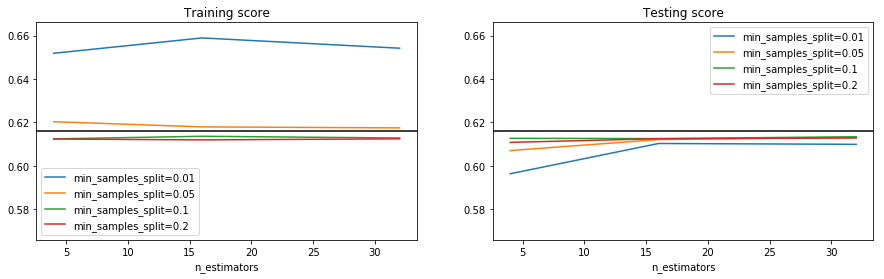

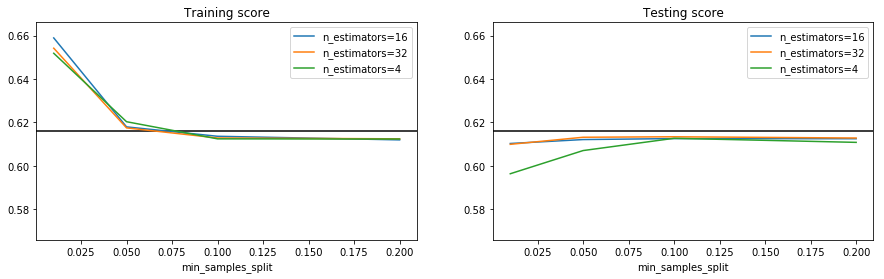

In [380]:
def plot_results(res):
    training = map(lambda r: r['training_accuracy'], res)
    testing = map(lambda r: r['testing_accuracy'], res)
    
    param_names = res[0]['parameters'].keys()
    series = {}
    for name in param_names:
        values = list(map(lambda r: repr(r['parameters'][name]), res))
        series[name] = values
    
    # TODO: plot heatmap
    
    series['training_score'] = list(training)
    series['testing_score'] = list(testing)
    
    df = pandas.DataFrame(series)
    #print(df)
    
    # .plot(figsize=(4,4), sharex=True, sharey=True)
    
    target = 0.616
    spread = 0.05
    # multiline plot with group by 
    def plot_score_trend(group_key, x_key):
        fig, (train_ax, test_ax) = plt.subplots(1, 2, figsize=(15, 4))
        train_ax.set_title("Training score")
        test_ax.set_title("Testing score")
        train_ax.set_xlabel(x_key)
        test_ax.set_xlabel(x_key)
        train_ax.set_ylim(target-spread, target+spread)
        test_ax.set_ylim(target-spread, target+spread)
        test_ax.axhline(y=target, color='black')
        train_ax.axhline(y=target, color='black')
        
        for val, group in df.groupby(group_key):
            label = '{}={}'.format(group_key, val)
            x = [ float(x) for x in group[x_key]]
            train_ax.plot(list(x), list(group['training_score']), label=label)
            test_ax.plot(list(x), list(group['testing_score']), label=label)

        train_ax.legend()
        test_ax.legend()
        return fig
    
    # TODO: unhardcode
    first, second = param_names
    fig1 = plot_score_trend(first, second)
    fig2 = plot_score_trend(second, first)

    return fig1, fig2

plot_results(r);

Feature ranking:
1. 28 : shot_type_Jump Shot (0.231529)
2. 26 : shot_type_Dunk (0.179321)
3. 5 : shot_distance_squared (0.168227)
4. 4 : shot_distance (0.146214)
5. 2 : period_time (0.065178)
6. 29 : shot_type_Layup (0.047895)
7. 1 : loc_x (0.047501)
8. 25 : points_3PT Field Goal (0.032483)
9. 0 : game_time (0.011582)
10. 65 : period_4 (0.005878)
11. 24 : season_2015-16 (0.004331)
12. 30 : shot_type_Tip Shot (0.004053)
13. 45 : opponent_MIL (0.003107)
14. 11 : season_2002-03 (0.002583)
15. 14 : season_2005-06 (0.001707)
16. 20 : season_2011-12 (0.001668)
17. 19 : season_2010-11 (0.001665)
18. 7 : season_1998-99 (0.001663)
19. 6 : season_1997-98 (0.001593)
20. 41 : opponent_IND (0.001514)
21. 37 : opponent_DEN (0.001478)
22. 17 : season_2008-09 (0.001468)
23. 51 : opponent_OKC (0.001451)
24. 50 : opponent_NYK (0.001440)
25. 55 : opponent_POR (0.001326)
26. 46 : opponent_MIN (0.001298)
27. 35 : opponent_CLE (0.001280)
28. 18 : season_2009-10 (0.001279)
29. 53 : opponent_PHI (0.001229)
30

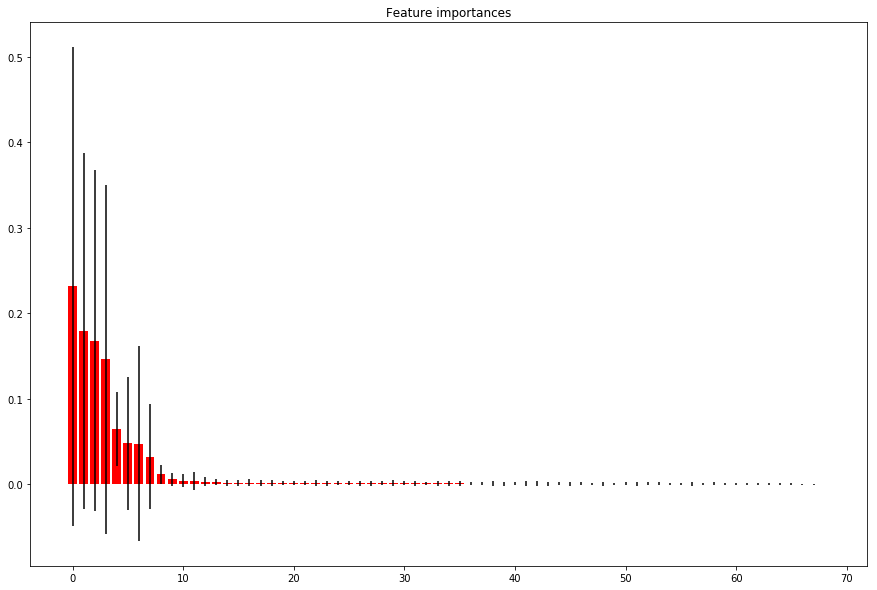

In [359]:
import numpy as np

def plot_forest_importance(forest):

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %d : %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]), )

    # Plot the feature importances of the forest
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title("Feature importances")
    ax.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    #ax.set_xticks(range(X.shape[1]), indices)
    #ax.set_xlim([-1, X.shape[1]])
    return fig

plot_forest_importance(best_model);


In [360]:
def make_submission(model, data):    
    assert compete_set['shot_id'].shape[0] == 5000, compete_set.shape
    assert compete_set['shot_id'].values[0] == 4
    assert compete_set['shot_id'].values[-1] == 30693
    
    Y_comp = model.predict(data)
    
    out = compete_set.copy()
    out['shot_made_flag'] = Y_comp.astype(numpy.float)
    out.to_csv('./submission.csv', index=False, columns=['shot_id', 'shot_made_flag'])

compete_set = preprocessed[pandas.isna(preprocessed['shot_made_flag'])]
make_submission(best_model, encoder.transform(compete_set))

# Data exploration

TRY? a dimenson reduction technique to get a feel for the data. PCA/PSLR ?


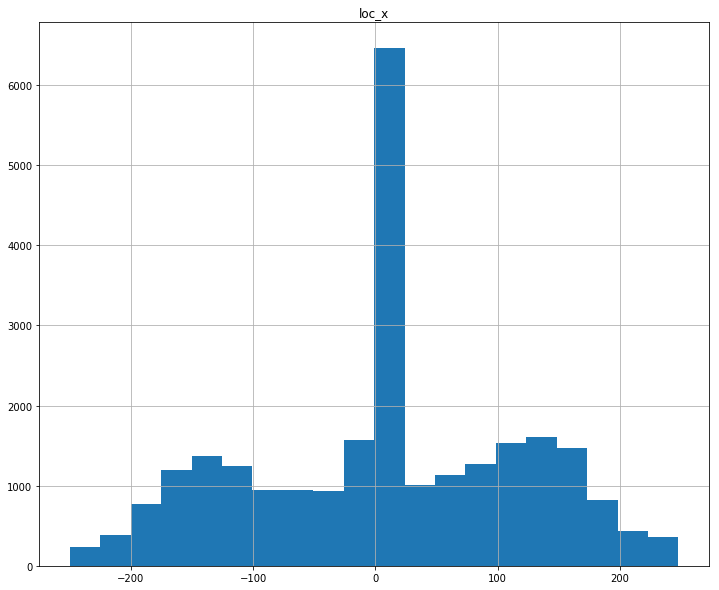

In [155]:
preprocessed.hist(column='loc_x', bins=20, figsize=(12,10), sharey=True);

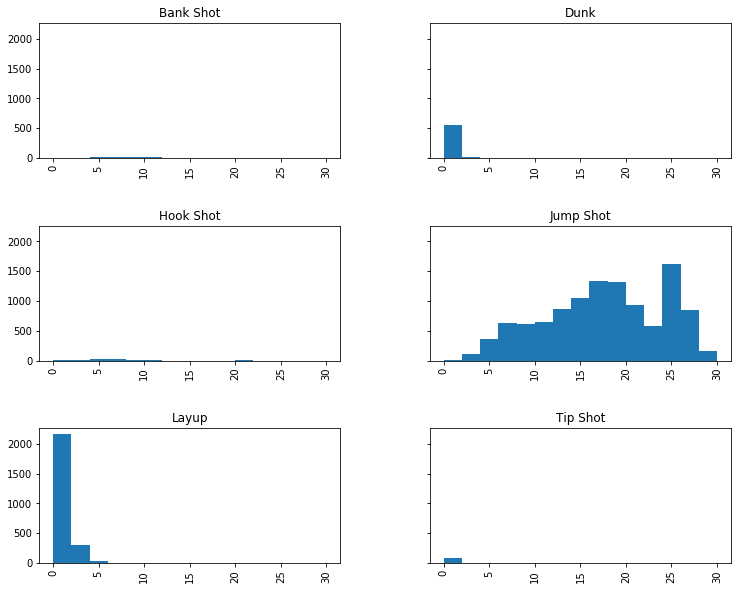

In [167]:
training.hist(column='shot_distance', by='combined_shot_type',
              bins=15, range=(0.0, 30.0), figsize=(12,10), sharey=True
);

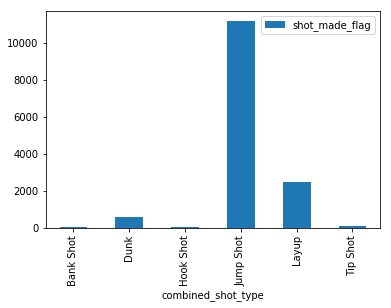

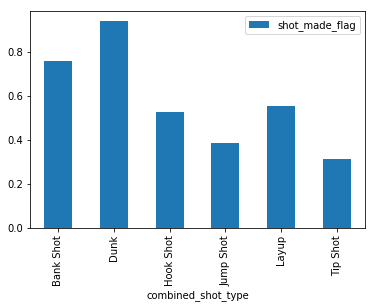

In [169]:
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'count'}).plot(kind='bar')
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

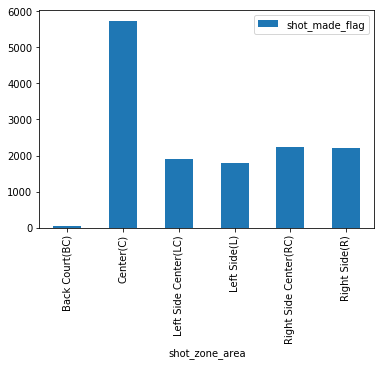

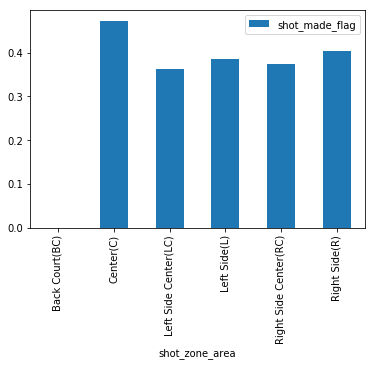

In [173]:
shot_zone = training[training['combined_shot_type'] != 'Dunk'].groupby(['shot_zone_area'])
shot_zone.agg({'shot_made_flag': 'count'}).plot(kind='bar')
shot_zone.agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [150]:
shot_area_type = training.groupby(['shot_zone_area', 'combined_shot_type'])
shot_area_type.agg({'shot_made_flag': 'mean'}).sort_values(by='shot_made_flag', ascending=False).plot(kind='bar')

NameError: name 'training' is not defined

In [174]:
training['season'].unique()

array(['2004-05', '1997-98', '2006-07', '2012-13', '2003-04', '2005-06',
       '2000-01', '2009-10', '2002-03', '2007-08', '2015-16', '2010-11',
       '1998-99', '2001-02', '1999-00', '2013-14', '2008-09', '2011-12',
       '1996-97', '2014-15'], dtype=object)

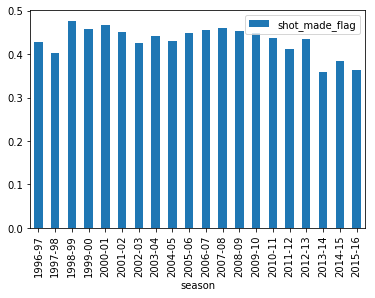

In [175]:
training.groupby(['season']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [11]:
training['opponent'].unique()

array(['DET', 'DAL', 'HOU', 'LAC', 'SAC', 'CHA', 'GSW', 'UTA', 'MIL',
       'IND', 'POR', 'NYK', 'NOH', 'VAN', 'NOP', 'MEM', 'OKC', 'MIN',
       'ORL', 'NJN', 'DEN', 'CLE', 'MIA', 'SEA', 'CHI', 'SAS', 'BOS',
       'PHX', 'WAS', 'TOR', 'PHI', 'ATL', 'BKN'], dtype=object)

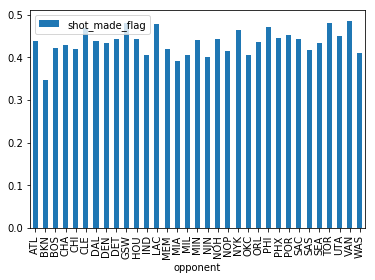

In [30]:
training.groupby(['opponent']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [ ]:
# BKN is an outlier, very few matches

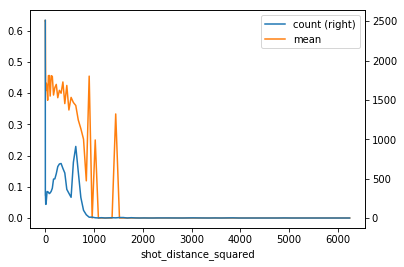

In [202]:
type_by_distance = training[training['combined_shot_type'] != '2Jump Shot'].groupby(['shot_distance_squared'])
count = type_by_distance.agg({'shot_made_flag': 'count'})
mean = type_by_distance.agg({'shot_made_flag': 'mean'})
df = pandas.DataFrame({'count': count['shot_made_flag'], 'mean': mean['shot_made_flag']}, index=count.index)
df.plot(secondary_y='count')

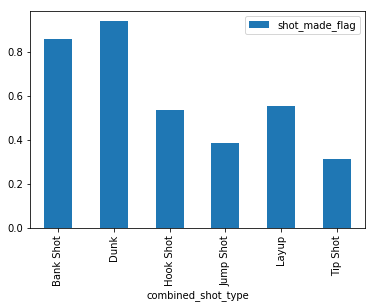

In [95]:
training[training['shot_distance'] < 5.0].groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

d [ 0.  2.  7. 12. 15. 17. 19. 23. 25. 79.]
e 0 2.0
e 10 2.0
e 10 7.0
e 10 12.0
e 26 2.0
e 26 7.0
e 26 12.0
e 26 15.0
e 26 17.0
e 26 19.0
e 26 23.0
e 26 25.0
e 26 79.0
e 26 2.0
e 26 7.0
e 26 12.0
e 26 15.0
e 26 17.0
e 26 19.0
e 26 23.0
e 26 25.0
e 26 79.0
e 0 2.0
e 0 2.0
e 25 2.0
e 25 7.0
e 25 12.0
e 25 15.0
e 25 17.0
e 25 19.0
e 25 23.0
e 25 25.0
e 25 79.0
e 3 2.0
e 3 7.0
e 17 2.0
e 17 7.0
e 17 12.0
e 17 15.0
e 17 17.0
e 17 19.0
e 0 2.0


,shot_distance,distance_class
5862,0,0
20287,10,2
9367,26,8
16878,26,8
4486,0,0
9591,0,0
7325,25,8
9019,3,1
688,17,5
13191,0,0


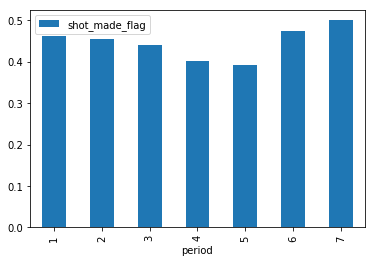

In [251]:
training.groupby(['period']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')